# Set up Env

In [1]:
!sudo pip install --upgrade azure-quantum
!pip install azure-quantum[qiskit]

%load_ext autoreload
%autoreload 2

In [2]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = " * ENTER YOUR ID * ",
    location = " * ENTER YOUR REGION * "
)

The current version of qiskit terra (0.19.1) contains a [bug](https://github.com/Qiskit/qiskit-terra/pull/7551) that makes time evolved Pauli operation not work correctly. This snippet is used to patch this bug.

In [3]:
import qiskit
from qiskit.quantum_info.operators import Pauli
from qiskit.circuit.quantumcircuit import QuantumCircuit
import numpy as np


if qiskit.__version__ <= '0.19.1':
    
    def _two_qubit_evolution(pauli, time, cx_structure):
        # get the Paulis and the qubits they act on
        labels_as_array = np.array(list(reversed(pauli.to_label())))
        qubits = np.where(labels_as_array != "I")[0]
        labels = np.array([labels_as_array[idx] for idx in qubits])

        definition = QuantumCircuit(pauli.num_qubits)

        # go through all cases we have implemented in Qiskit
        if all(labels == "X"):  # RXX
            definition.rxx(2 * time, qubits[0], qubits[1])
        elif all(labels == "Y"):  # RYY
            definition.ryy(2 * time, qubits[0], qubits[1])
        elif all(labels == "Z"):  # RZZ
            definition.rzz(2 * time, qubits[0], qubits[1])
        elif labels[0] == "Z" and labels[1] == "X":  # RZX
            definition.rzx(2 * time, qubits[0], qubits[1])
        elif labels[0] == "X" and labels[1] == "Z":  # RXZ
            definition.rzx(2 * time, qubits[1], qubits[0])
        else:  # all the others are not native in Qiskit, so use default the decomposition
            definition = _multi_qubit_evolution(pauli, time, cx_structure)

        return definition

    qiskit.synthesis.evolution.product_formula._two_qubit_evolution = _two_qubit_evolution

# Minesweeper
Define your board here. The format is as follows:

**0-8** indicates how many mines are adjacent to a field   
**.** or **x** indicates a field that we cant to solve for (you can use the x to help visualize where the bombs are)   
**_** indicates a field that you don't care about

In [4]:
board = '''
0001....
0001112.
0000002.
00000011
00000000
00000000
11211000
....1000
'''[1:-1]

## Set up Hamiltonian Cost Functions
QAOA uses the adiabatic process to transition from the minimum eigenstate from one function to the minimum eigenstate of another function.   
For that we must define a hamiltonian that describes the cost/penalty of each poossible board state.

In [5]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

from minesweeper import MinesweeperQiskit

op_pubo, n_qubits = MinesweeperQiskit().construct_board_op(board, mod_2=False)
op, n_qubits = MinesweeperQiskit().construct_board_op(board, mod_2=True)

# Calculate Depth
evo_gate = PauliEvolutionGate(op, 0, synthesis=LieTrotter(reps=1))
decomposed = evo_gate.definition.decompose()
print(f'Depth with p=1: {decomposed.depth()}')

print(f'Num qubits: {n_qubits}')
print()
print(op)
print()
print('Representing the board:')
print(board)

Depth with p=1: 16
Num qubits: 10

7.0 * IIIIIIIIII
+ 1.0 * ZIIIIIIIII
+ 0.5 * ZZIIIIIIII
+ 0.5 * ZZZIIIIIII
+ 1.0 * IIIIIZIIII
- 0.5 * IIIIZZIIII
- 0.5 * IZZZZZIIII
+ 0.5 * IIIIIIZZII
+ 0.5 * IIIIIIZZZI
+ 1.0 * IIIIIIIIIZ
+ 0.5 * IIIIIIIIZZ
- 0.5 * IIIIIIIZZZ

Representing the board:
0001....
0001112.
0000002.
00000011
00000000
00000000
11211000
....1000


## Warm-starting QAOA
To help our optimization algorithm to converge faster, we use a technique called warm-starting. It was first described in a [paper by Egger et al.](https://arxiv.org/pdf/2009.10095.pdf) in 2021.

We use a classical optimization algorithm to find an approximate solution. Finding the optimal solution to a polynomial unconstrained binary optimization problem (PUBO) is NP-hard (can be reduced to SAT), that's why we relax the requirement that it has to be a binary assignment, and instead turn it into a continuous optimization problem.

In [7]:
# Try warm starting qaoa
from scipy.optimize import dual_annealing, differential_evolution, minimize
import numpy as np
import random
from minesweeper import eval_cost

# Use the PUBO operation -> better pre_opt
paulis = list(zip(op_pubo.primitive.paulis.to_labels(), map(lambda x: x.real, op_pubo.primitive.coeffs)))

def objective_func(x, paulis, n_vars):
    cost = random.random() * 1e-7  # Add some noise to make toe solution worse
    
    for (pauli, coeff) in paulis:
        if pauli == ('I' * n_vars):
            cost += coeff
            continue
        
        labels_as_array = np.array(list(pauli))
        indices = np.where(labels_as_array == 'Z', x, np.ones(n_vars))
        cost += coeff * np.prod(indices)
    
    return cost

warm_start_res = dual_annealing(objective_func, args=(paulis, n_qubits), bounds=[(-1, 1)] * n_qubits, maxiter=50, callback=(lambda x, f, _: f <= 1))
# warm_start_res = minimize(objective_func, np.random.random(n_qubits), args=(paulis, n_qubits), method='SLSQP', bounds=[(-1, 1)] * n_qubits, options={'maxiter': 50})

print(warm_start_res)
solution = ''.join(['0' if x >= 0 else '1' for x in warm_start_res.x])
print(eval_cost(op, solution), solution)

     fun: 1.3507439458822899
 message: ['Maximum number of iteration reached']
    nfev: 5027
    nhev: 0
     nit: 50
    njev: 366
  status: 0
 success: True
       x: array([-0.92297124,  0.99458297,  0.87618843,  0.85748274, -0.49202784,
       -0.97502109,  0.90332739, -0.97605021,  0.73800029, -0.99509567])
0.0 1000110101


Using the approximate solution that we just found, we can now construct the initial and mixer circuit. This part is based on the following [tutorial](https://qiskit.org/documentation/optimization/tutorials/10_warm_start_qaoa.html).

In [8]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# https://arxiv.org/pdf/2009.10095.pdf
eps = 0.25  # eps in [0, 0.5]

c_stars = np.flip(warm_start_res.x)  # Ternary logic
c_stars = 0.5 * (1 - c_stars)        # Binary logic
c_stars = np.minimum(np.maximum(c_stars, eps), 1-eps)
thetas = 2 * np.arcsin(np.sqrt(c_stars))

# Construct Initializing QC (Use instead of equal superposition)
init_qc = QuantumCircuit(n_qubits)
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)
    
# Construct mixer circuit
beta = Parameter('β')
ws_mixer = QuantumCircuit(n_qubits)
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

## QAOA
Finally we now are ready to construct our QAOA circuit and run an optimizer on it to improve on our initial guess by finding the optimal values for β and γ.

Sadly we can't realy use the ionq.simulator backend for this step, because of the wait time between optimization loops.

In [9]:
# Define the QAOA
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP


from minesweeper import QAOACallback

# optimizer = COBYLA(maxiter=50, disp=True, rhobeg=22/7)
optimizer = SLSQP(maxiter=100, disp=True)
# optimizer = SPSA(maxiter=25, callback=(lambda *args: print(args)))

# backend = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('qasm_simulator')
# backend = provider.get_backend('ionq.simulator')

qaoa_callback = QAOACallback()
ws_qaoa = QAOA(
    reps=1,
    optimizer=optimizer,
    quantum_instance=backend,
    include_custom=True,
    initial_state=init_qc,
    mixer=ws_mixer,
    callback=qaoa_callback.callback
)
ws_qaoa.quantum_instance.run_config.shots = 2**15

In [10]:
result = ws_qaoa.compute_minimum_eigenvalue(op)

print(f'cost_function_evals: {result.cost_function_evals}')
print(f'optimal_point: {result.optimal_point}')
print(f'optimal_value: {result.optimal_value}')
print(f'optimizer_time: {result.optimizer_time}')

0001 7.13  -  [ 1.2726826  -4.76801681]
0002 7.13  -  [ 1.27268261 -4.76801681]
0003 7.13  -  [ 1.2726826 -4.7680168]
0004 4.60  -  [ 0.09154146 -2.52549576]
0005 4.60  -  [ 0.09154147 -2.52549576]
0006 4.60  -  [ 0.09154146 -2.52549575]
0007 5.26  -  [ 0.98726109 -3.04132206]
0008 4.14  -  [ 0.42559266 -2.7178689 ]
0009 4.14  -  [ 0.42559267 -2.7178689 ]
0010 4.14  -  [ 0.42559266 -2.71786888]
0011 6.35  -  [ 1.1868337  -5.60341877]
0012 7.94  -  [ 0.67261085 -3.6542127 ]
0013 4.10  -  [ 0.45757532 -2.83910195]
0014 4.10  -  [ 0.45757534 -2.83910195]
0015 4.10  -  [ 0.45757532 -2.83910194]
0016 4.06  -  [ 0.35862955 -2.78641178]
0017 4.06  -  [ 0.35862956 -2.78641178]
0018 4.06  -  [ 0.35862955 -2.78641176]
0019 4.06  -  [ 0.37006378 -2.79217457]
0020 4.06  -  [ 0.3700638  -2.79217457]
0021 4.06  -  [ 0.37006378 -2.79217456]
0022 4.06  -  [ 0.36917745 -2.79266138]
0023 4.06  -  [ 0.36917747 -2.79266138]
0024 4.06  -  [ 0.36917745 -2.79266137]
Optimization terminated successfully    (E

# Result Visualization

In [13]:
# Randomly sample the parameter space.

import itertools

from qiskit import ClassicalRegister, QuantumCircuit
from qiskit.utils.run_circuits import find_regs_by_name

samples = []

for initial_point in range(100):
    initial_point = np.concatenate((np.random.random((1,)) * np.pi, np.random.random((1,)) * 2*np.pi))
    qc = ws_qaoa.construct_circuit(initial_point, op)[0]
    
    min_vector = {}
    if ws_qaoa._quantum_instance.is_statevector:
        ret = ws_qaoa._quantum_instance.execute(qc)
        min_vector = ret.data()["statevector"]
    else:
        c = ClassicalRegister(qc.width(), name="c")
        q = find_regs_by_name(qc, "q")
        qc.add_register(c)
        qc.barrier(q)
        qc.measure(q, c)
        ret = ws_qaoa._quantum_instance.execute(qc)
        counts = ret.get_counts(qc)
        # normalize, just as done in CircuitSampler.sample_circuits
        shots = ws_qaoa._quantum_instance._run_config.shots
        min_vector = {b: (v / shots) ** 0.5 for (b, v) in counts.items()}
    
    cost = sum([eval_cost(op, bs) * amp**2 for bs, amp in min_vector.items()])
    samples.append((list(initial_point), cost))
    
    print(cost, initial_point)

6.861846923828125 [1.33367594 0.66770897]
3.753753662109375 [2.17604166 5.95134822]
7.301177978515625 [1.71126929 1.38017619]
4.651885986328125 [3.07188452 5.28439289]
6.129608154296875 [0.81401726 3.05425389]
2.24664306640625 [0.54366081 0.45023456]
6.4039306640625 [0.36122809 2.51562278]
5.0203857421875 [0.05706801 2.64100243]
8.371246337890625 [0.42112866 5.77409247]
7.890106201171875 [1.47878361 3.85103685]
8.251434326171875 [1.57101815 5.26134781]
4.459442138671875 [2.03253733 5.90325182]
7.151336669921875 [1.07920142 5.93442596]
5.74951171875 [0.49419421 2.21204431]
5.935821533203125 [0.39331505 4.459905  ]
4.4232177734375 [0.21989506 0.95515631]
7.331634521484375 [1.01100308 4.55394197]
6.079345703125 [2.18873018 4.53857389]
4.47454833984375 [0.02840433 0.52091319]
7.348785400390625 [0.97485451 1.19225765]
4.391754150390625 [2.82802836 2.58520346]
6.242340087890625 [2.57782796 4.91837701]
4.716339111328125 [0.12651696 0.01319482]
5.937164306640625 [0.53642118 1.45215704]
7.09936

[([1.3336759387192756, 0.6677089684202453], 6.861846923828125),
 ([2.176041659085484, 5.951348215966524], 3.753753662109375),
 ([1.7112692947160788, 1.3801761925007339], 7.301177978515625),
 ([3.0718845213490975, 5.284392886097409], 4.651885986328125),
 ([0.8140172616534754, 3.054253888407211], 6.129608154296875),
 ([0.5436608104523515, 0.4502345570774591], 2.24664306640625),
 ([0.3612280933042362, 2.5156227782982583], 6.4039306640625),
 ([0.05706801427460605, 2.6410024344066576], 5.0203857421875),
 ([0.42112865570030084, 5.774092473401556], 8.371246337890625),
 ([1.4787836061239683, 3.8510368469213905], 7.890106201171875),
 ([1.571018148120616, 5.261347813637698], 8.251434326171875),
 ([2.0325373330103846, 5.903251818053804], 4.459442138671875),
 ([1.0792014207100928, 5.934425959362632], 7.151336669921875),
 ([0.4941942052322317, 2.2120443062991217], 5.74951171875),
 ([0.3933150541769205, 4.459905004940526], 5.935821533203125),
 ([0.2198950598257386, 0.9551563063732049], 4.42321777343

In [37]:
# Compute values for contour plot
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed


if len(samples) > 0:
    s_xy,s_z = zip(*samples)
    s_x, s_y = zip(*s_xy)
else:
    s_x, s_y, s_z = [], [], []

o_x, o_y = zip(*qaoa_callback.params)
o_x = np.mod(o_x, np.pi)   # Beta
o_y = np.mod(o_y, np.pi*2) # Gamma
o_z = np.array(qaoa_callback.mean)

x = np.concatenate((o_x, s_x))
y = np.concatenate((o_y, s_y))
z = np.concatenate((o_z, s_z))

# define grid.
xi = np.linspace(0,np.pi,100)
yi = np.linspace(0,2*np.pi,100)
zi = griddata((x, y), -z, (xi[None,:], yi[:,None]), method='linear')

1000110101 4.687499999999999


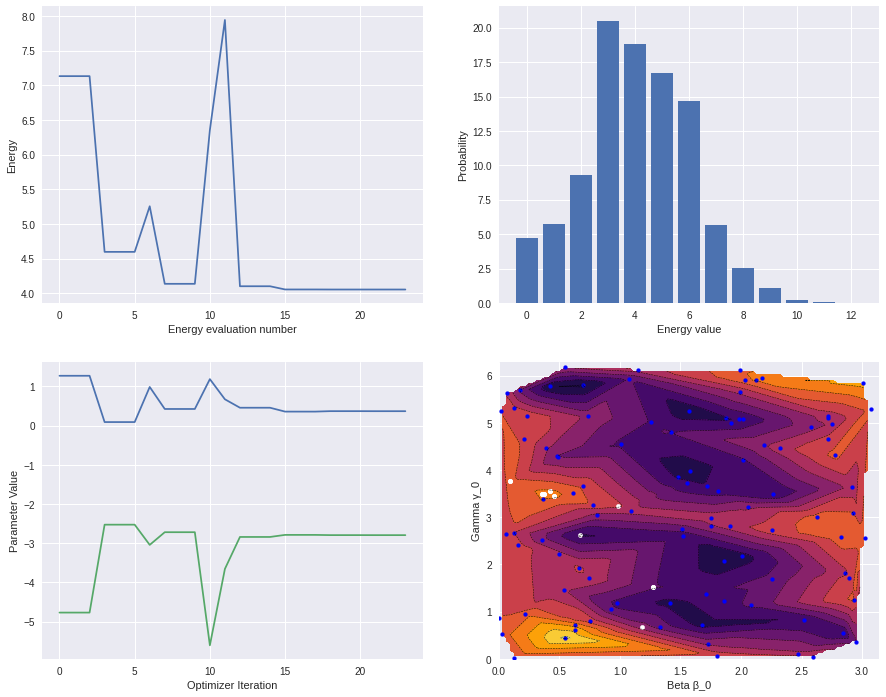

In [38]:
from collections import defaultdict
from minesweeper import get_eigenstates

import matplotlib.pyplot as plt
plt.style.use('seaborn')

eigenstates = get_eigenstates(result)

def get_cost_values(es, op):
    vals = defaultdict(float)
    
    for (sample, amp) in es.items():
        cost = eval_cost(op, sample)
        prob = amp ** 2 * 100
        vals[cost] += prob
        
        if cost == 0:
            print(sample, prob)
    
    return vals


cost_vals = get_cost_values(eigenstates, op)

# Draw Figures
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs[0][0].plot(qaoa_callback.mean)
axs[0][0].set_xlabel("Energy evaluation number")
axs[0][0].set_ylabel("Energy")

axs[0][1].bar(list(cost_vals.keys()), list(cost_vals.values()))
axs[0][1].set_xlabel("Energy value")
axs[0][1].set_ylabel("Probability")

axs[1][0].plot(qaoa_callback.params)
axs[1][0].set_xlabel("Optimizer Iteration")
axs[1][0].set_ylabel("Parameter Value")

axs[1][1].contour(xi,yi,zi,10,linewidths=0.5,colors='k')
axs[1][1].contourf(xi,yi,zi,10, cmap=plt.cm.inferno)
axs[1][1].scatter(s_x,s_y,marker='o',c='b',s=15)
axs[1][1].scatter(o_x,o_y,marker='o',c='w',s=20)
axs[1][1].set_xlabel('Beta β_0')
axs[1][1].set_ylabel('Gamma γ_0')

pass

# Test on real QPU

In [40]:
# Run on actual quantum hardware

from qiskit import transpile
from qiskit import ClassicalRegister, QuantumCircuit
from qiskit.tools.monitor import job_monitor
from qiskit.utils.run_circuits import find_regs_by_name


qc = ws_qaoa.get_optimal_circuit()

c = ClassicalRegister(qc.width(), name='c')
q = find_regs_by_name(qc, 'q')
qc.add_register(c)
qc.barrier(q)
qc.measure(q, c)


transpiled_circuit = transpile(qc, basis_gates=['rx', 'rz', 'ry', 'cx'], optimization_level=3)

qpu_backend = provider.get_backend('ionq.qpu')
qpu_job = qpu_backend.run(transpiled_circuit, shots=1024)
job_id = qpu_job.id()
print("Job id", job_id)

/tmp/ipykernel_1424/2493623225.py:9: DeprecationWarning: 
The VQE.get_optimal_circuit method is deprecated as of Qiskit Terra
0.18.0 and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.ansatz.bind_parameters(VQEResult.optimal_point).
  qc = ws_qaoa.get_optimal_circuit()


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code RMJVTXJ9Q to authenticate.
Job id 752e051a-81e1-11ec-b04d-d1daa6a14ac1


Job Status: job has successfully run
1000110101 4.687499999999999


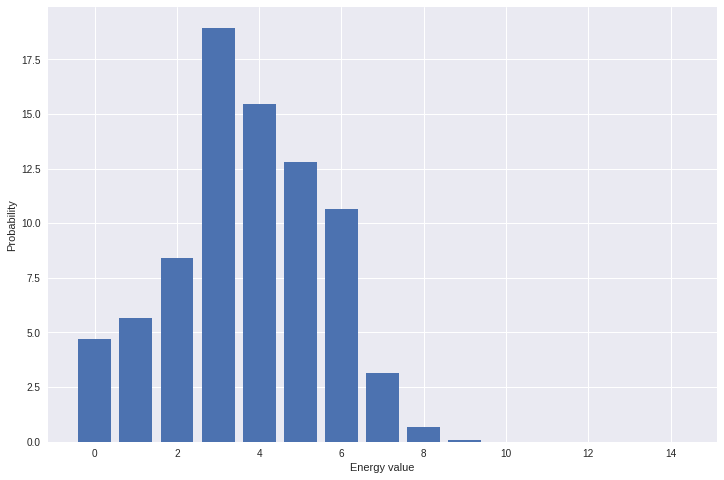

In [54]:
job_monitor(qpu_job)

eigenstates = {k: np.sqrt(v/1024) for k,v in qpu_job.result().get_counts().items()}
cost_vals = get_cost_values(eigenstates, op)

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.bar(list(cost_vals.keys()), list(cost_vals.values()))
axs.set_xlabel("Energy value")
axs.set_ylabel("Probability")

pass